In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.5.0+cu101
0.6.0+cu101


In [0]:
# Import data
img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

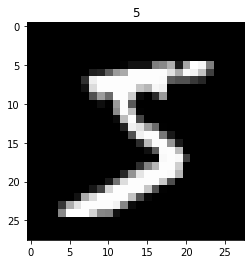

In [4]:
# View sample image from train set 
sample = next(iter(train_dataset))
image, label = sample

plt.imshow(image.squeeze(0), cmap = 'gray')
plt.title(label);

In [0]:
# Define helper function to add noise
def add_noise(img, noise_factor):
  noise = torch.randn(*img.shape) * noise_factor
  img = img + noise
  img = np.clip(img, 0., 1.)
  return img

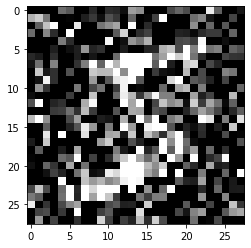

In [6]:
# View a sample with noise added
noisy_img = add_noise(image, .5)
plt.imshow(noisy_img.squeeze(0), cmap='gray');

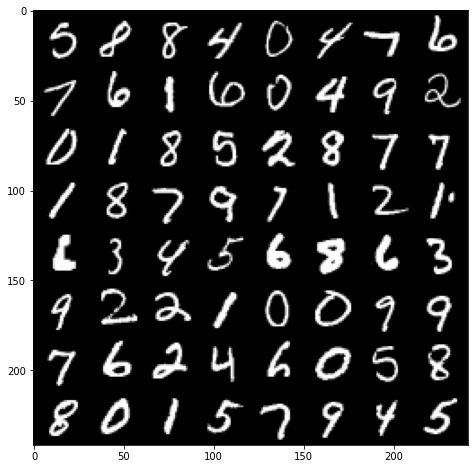

In [7]:
# View a batch of images
batch = next(iter(train_dataloader))
images, labels = batch

grid = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])))
grid = np.transpose(grid, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(grid);

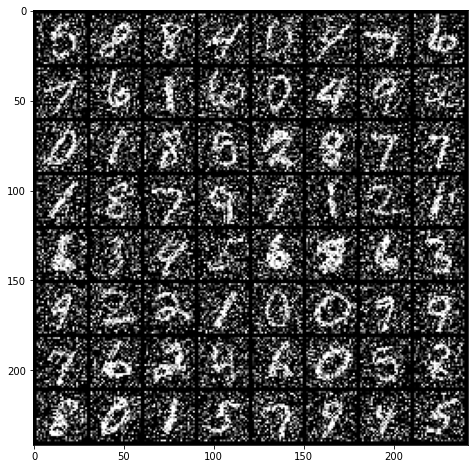

In [8]:
# View the same batch with noise added
noisy_imgs = add_noise(images, 0.5)

noisy_grid = torchvision.utils.make_grid(noisy_imgs)
noisy_grid = np.transpose(noisy_grid, (1, 2, 0))

plt.figure(figsize=(8,8))
plt.imshow(noisy_grid);

In [9]:
# Create a simple model as model optimization is not the goal of this notebook

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=32, 
                               kernel_size=4, 
                               stride=2, padding=1
                               ) # out: 32 x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1
                               ) # out: 64 x 7 x 7
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv2 = nn.ConvTranspose2d(in_channels=64, 
                                        out_channels=32, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=32, 
                                        out_channels=1, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
            
    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # sigmoid since we will use BCE loss
        return x
    
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = DenoisingAutoencoder()
model = model.to(device)
print(model)

DenoisingAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


In [10]:
# Hyperparameters
num_epochs = 20
learning_rate = 1e-3
noise_factor = 0.5

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    # For tracking loss
    train_loss = 0.0
    
    for batch in train_dataloader:
        images, _ = batch
        
        # Add noise
        noisy_imgs = add_noise(images, noise_factor)

        # Move to gpu
        images = images.to(device)
        noisy_imgs = noisy_imgs.to(device)
        
        # Obtain outputs
        optimizer.zero_grad()
        outputs = model(noisy_imgs)

        # Calculate loss and step down the grad field
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        # Update loss
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_dataloader)
    print(f'Epoch: {epoch+1} \tTraining Loss: {round(train_loss, 3)}')

Epoch: 1 	Training Loss: 8.366
Epoch: 2 	Training Loss: 6.513
Epoch: 3 	Training Loss: 6.382
Epoch: 4 	Training Loss: 6.299
Epoch: 5 	Training Loss: 6.252
Epoch: 6 	Training Loss: 6.208
Epoch: 7 	Training Loss: 6.177
Epoch: 8 	Training Loss: 6.148
Epoch: 9 	Training Loss: 6.131
Epoch: 10 	Training Loss: 6.115
Epoch: 11 	Training Loss: 6.097
Epoch: 12 	Training Loss: 6.086
Epoch: 13 	Training Loss: 6.078
Epoch: 14 	Training Loss: 6.073
Epoch: 15 	Training Loss: 6.064
Epoch: 16 	Training Loss: 6.062
Epoch: 17 	Training Loss: 6.052
Epoch: 18 	Training Loss: 6.051
Epoch: 19 	Training Loss: 6.043
Epoch: 20 	Training Loss: 6.043


In [0]:
# obtain one batch of test images
batch = next(iter(test_dataloader))
images, labels = batch

# add noise to the test images
noisy_imgs = add_noise(images, 0.5)
noisy_imgs = noisy_imgs.to(device)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu()
noisy_imgs = noisy_imgs.numpy()

# Use detach when it's an output that requires_grad
output = output.cpu()
output = output.detach().numpy()

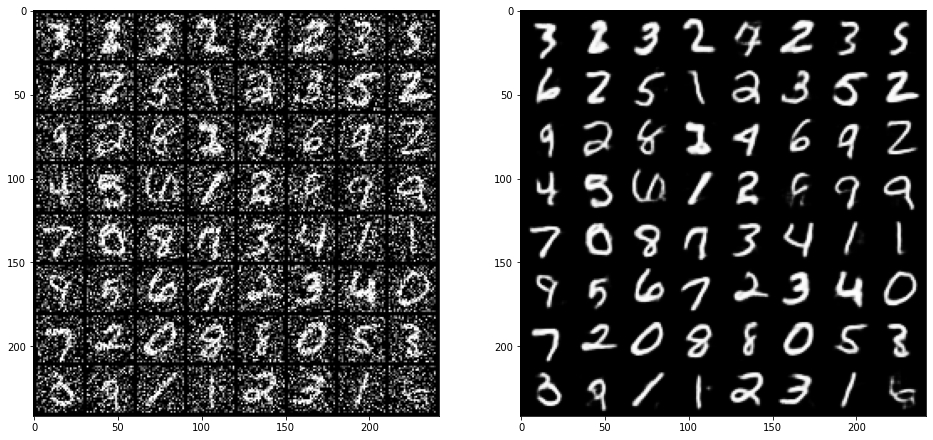

In [14]:
noisy_grid = torchvision.utils.make_grid(torch.from_numpy(noisy_imgs), nrow=8)
noisy_grid = np.transpose(noisy_grid, (1, 2, 0))

cleaned_grid = torchvision.utils.make_grid(torch.from_numpy(output), nrow=8)
cleaned_grid = np.transpose(cleaned_grid, (1, 2, 0))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
plt.subplot(121)
plt.imshow(noisy_grid.squeeze(0), cmap ='gray')
plt.subplot(122)
plt.imshow(cleaned_grid.squeeze(0), cmap='gray');